https://www.kaggle.com/competitions/playground-series-s3e13/data?select=test.csv"

Cool solution
https://www.kaggle.com/code/davidcoxon/complete-eda-data-egineering-and-model-comparison

In [64]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold, cross_val_score

# Download latest version
!kaggle competitions download -c playground-series-s3e13

#
#path = Path (kagglehub.dataset_download("https://www.kaggle.com/competitions/playground-series-s3e13/data?select=test.csv"))
#print ("Path to dataset files:", path)
#data_set_name = Path ("Titanic-Dataset.csv")
#s0 = pd.read_csv(path / data_set_name, header=None)
#s0

playground-series-s3e13.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
import zipfile 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

from Common import *
# Extract all contents of the ZIP file

def vbpd_attributes():
    
    with zipfile.ZipFile("playground-series-s3e13.zip", 'r') as zip_ref:
        zip_ref.extractall("playground-series-s3e13")

    print("Files extracted successfully!")

    test_name = Path ("test.csv")
    train_name = Path ("train.csv")

    test = pd.read_csv( "playground-series-s3e13" / test_name )
    train = pd.read_csv( "playground-series-s3e13" / train_name )

    random_seed = 32
    random.seed(random_seed)

    y = train["prognosis"]
    #y = y.to_frame()
    X = train.drop (columns = ["prognosis"])

    X = X.drop (columns = ["id"])

    X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=random_seed)

    # Label encoding
    label_encoder = LabelEncoder()
    label_encoder.fit(y)  # Fit on the entire 'prognosis' column

    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)

    y_train = y_train.squeeze()

    print("Shapes:")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("y_train:", y_train.shape)
    print("y_test:", y_test.shape)

    return X_train,X_test,y_train,y_test

X_train, X_test, y_train, y_test = vbpd_attributes()


Files extracted successfully!
Shapes:
X_train: (565, 64)
X_test: (142, 64)
y_train: (565,)
y_test: (142,)


In [66]:
from sklearn.metrics import accuracy_score, make_scorer

param_grid = [
    {
        "classifier": [SVC()],
        "classifier__kernel": ["linear", "rbf"],
        "classifier__C": [0.1, 1, 10]
    },
    {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [50, 100],
        "classifier__max_depth": [None, 5, 10],
        "classifier__min_samples_split": [2, 5]
    },
    {
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": [3, 5, 7],
        "classifier__weights": ["uniform", "distance"]
    },
    {
        "classifier": [LogisticRegression(solver='saga', multi_class='ovr', max_iter=500)],
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ["l1", "l2"]
    }
]

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)


pipeline = Pipeline([
    ("classifier", SVC())  # Placeholder classifier
])

scorer = make_scorer(accuracy_score)


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring=scorer,
    verbose=2,
    n_jobs=-1  # Use all available CPU cores
)


# Fit Grid Search
grid_search.fit(X_train, y_train)


results_df = pd.DataFrame(grid_search.cv_results_)
# Select and display key columns
results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values(by='rank_test_score')

# Display the table
print("Grid Search Results:")
print(results_df)

# Optional: Pretty display in Jupyter or a file
results_df.to_csv("grid_search_results.csv", index=False)  # Save results to CSV file

# Print the best model and hyperparameters
print("Best Model:", grid_search.best_estimator_)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

results_df.to_csv("grid_search_results.csv", index=False)
print("Results saved to grid_search_results.csv")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Grid Search Results:
                                               params  mean_test_score  \
15  {'classifier': RandomForestClassifier(), 'clas...         0.295575   
3   {'classifier': SVC(), 'classifier__C': 1, 'cla...         0.293805   
14  {'classifier': RandomForestClassifier(), 'clas...         0.290265   
9   {'classifier': RandomForestClassifier(), 'clas...         0.290265   
16  {'classifier': RandomForestClassifier(), 'clas...         0.288496   
12  {'classifier': RandomForestClassifier(), 'clas...         0.283186   
8   {'classifier': RandomForestClassifier(), 'clas...         0.281416   
0   {'classifier': SVC(), 'classifier__C': 0.1, 'c...         0.281416   
5   {'classifier': SVC(), 'classifier__C': 10, 'cl...         0.281416   
23  {'classifier': KNeighborsClassifier(), 'classi...         0.279646   
10  {'classifier': RandomForestClassifier(), 'clas...         0.276106   
7   {'classifier': RandomFore

C:\Users\Arath\AppData\Local\Temp\ipykernel_21556\994480434.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mean_test_score', y='hyperparam_combination', data=results_df, palette="Blues_d")


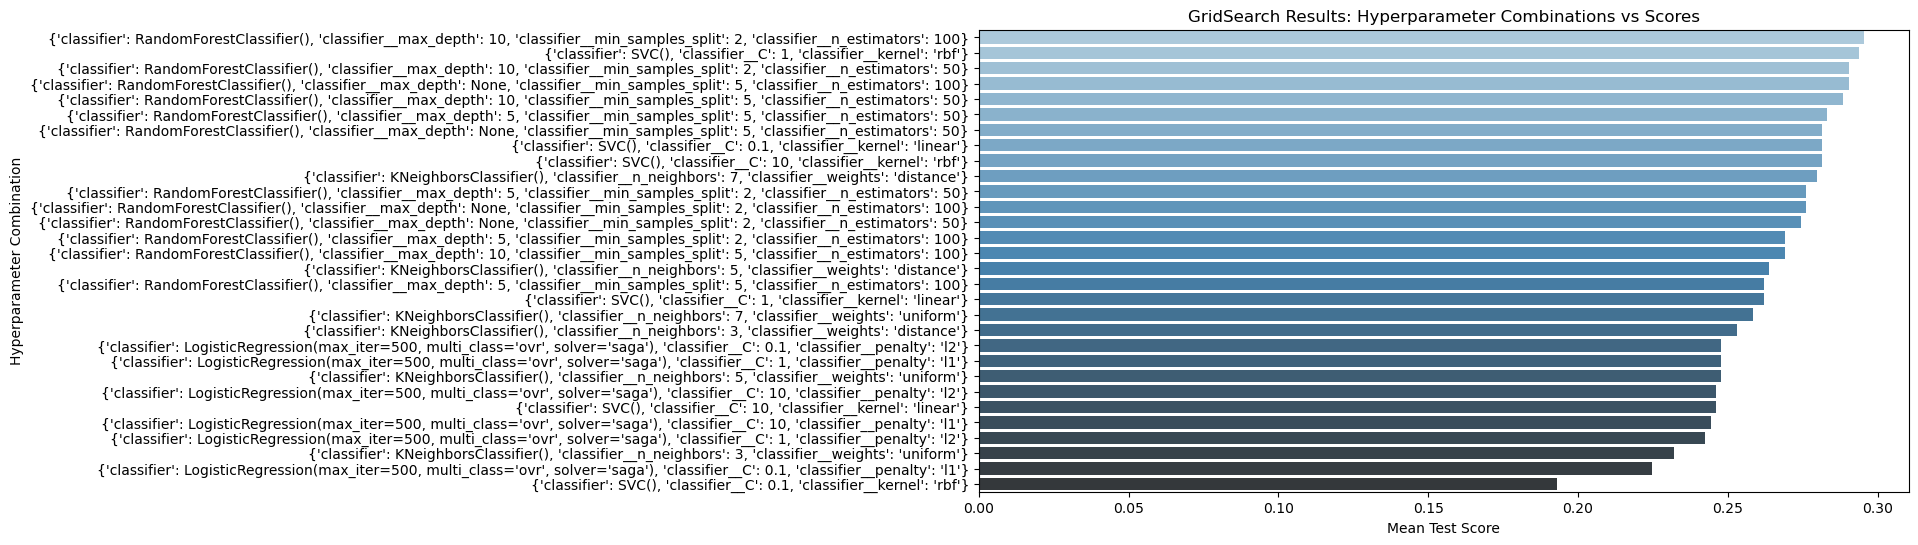

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert GridSearchCV results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Extract only relevant columns: hyperparameters and scores
results_df = results_df[['params', 'mean_test_score', 'rank_test_score']]

# Add a string representation of hyperparameter combinations for plotting
results_df['hyperparam_combination'] = results_df['params'].apply(lambda x: str(x))

# Sort results by rank
results_df = results_df.sort_values(by='rank_test_score')

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='mean_test_score', y='hyperparam_combination', data=results_df, palette="Blues_d")
plt.title("GridSearch Results: Hyperparameter Combinations vs Scores")
plt.xlabel("Mean Test Score")
plt.ylabel("Hyperparameter Combination")
plt.show()

In [72]:
# Expand the 'params' dictionary column into separate columns
params_df = pd.json_normalize(results_df['params'])

# Combine expanded parameters with the original scores and ranks
results_combined = pd.concat([params_df, results_df[['mean_test_score', 'rank_test_score']]], axis=1)

# Sort the results by rank
results_combined = results_combined.sort_values(by='rank_test_score')

# Display the table
print("Expanded Hyperparameter Table:")
results_combined.head()

Expanded Hyperparameter Table:


,classifier,classifier__max_depth,classifier__min_samples_split,classifier__n_estimators,classifier__C,classifier__kernel,classifier__n_neighbors,classifier__weights,classifier__penalty,mean_test_score,rank_test_score
15,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,5.0,distance,NaN,0.295575,1
3,RandomForestClassifier(),NaN,5.0,100.0,NaN,NaN,NaN,NaN,NaN,0.293805,2
14,RandomForestClassifier(),10.0,5.0,100.0,NaN,NaN,NaN,NaN,NaN,0.290265,3
9,KNeighborsClassifier(),NaN,NaN,NaN,NaN,NaN,7.0,distance,NaN,0.290265,4
16,RandomForestClassifier(),5.0,5.0,100.0,NaN,NaN,NaN,NaN,NaN,0.288496,5


Best Parameters: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Test Accuracy with Best Parameters: 0.3239
Test Precision with Best Parameters: 0.2959
Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  1  0  2  0  0]
 [ 0  0  6  0  1  0  0  1  5  4  0]
 [ 0  0  0  5  3  0  0  0  7  0  0]
 [ 1  0  0  1  2  2  0  0  2  1  1]
 [ 0  1  1  4  0  0  0  0  3  3  2]
 [ 0  3  1  0  0  0  2  4  3  0  0]
 [ 2  0  1  0  0  0  0 13  3  0  0]
 [ 1  0  2  1  2  1  1  2  4  1  1]
 [ 0  0  2  2  1  1  0  0  2  2  5]
 [ 0  0  0  0  0  0  3  0  3  1  1]]


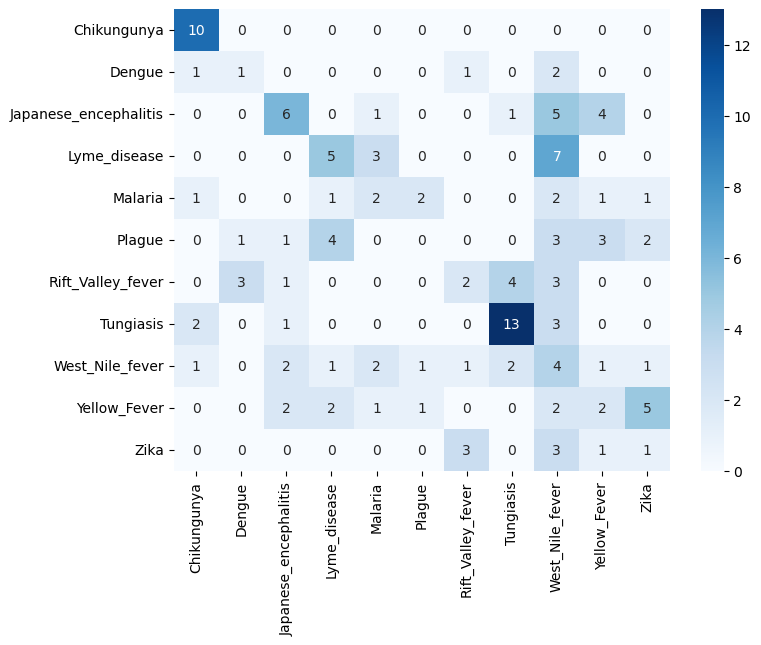

In [68]:

from sklearn.metrics import confusion_matrix


def print_mdl_metrics (x):
  return x
#
# Test set metrics
#
y_pred = grid_search.best_estimator_.predict(X_test)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
test_precision = precision_score(y_test, best_model.predict(X_test), average='macro')

print("Best Parameters:", grid_search.best_params_)
print(f"Test Accuracy with Best Parameters: {test_score:.4f}")
print(f"Test Precision with Best Parameters: {test_precision:.4f}")


y_test_decoded = label_encoder.inverse_transform (y_test)
y_predict_decoded = label_encoder.inverse_transform (y_pred)

cm = confusion_matrix (y_test_decoded, y_predict_decoded, labels=label_encoder.classes_)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)


print ("Confusion Matrix:\n", cm)